In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [2]:
epochs = 3
batch_size = 64
lr = 0.01
momentum = 0.5
log_interval = 10

In [3]:
# dataset init
train_dataset = torchvision.datasets.MNIST('./data/', train=True, download=True, 
                                           transform=transforms.Compose([
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.1307,),(0.3081,))
                                           ])
                                          )
test_dataset = torchvision.datasets.MNIST('./data/', train=False, download=True, 
                                           transform=transforms.Compose([
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.1307,),(0.3081,))
                                           ])
                                          )
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

torch.Size([64, 1, 28, 28])
tensor([9, 1, 1, 4, 4, 5, 6, 8, 0, 7, 9, 3, 4, 6, 3, 8, 6, 4, 9, 7, 0, 2, 0, 3,
        7, 4, 3, 3, 3, 2, 2, 1, 0, 9, 3, 9, 4, 3, 2, 2, 4, 7, 3, 2, 3, 3, 0, 0,
        0, 4, 0, 6, 2, 9, 5, 6, 9, 7, 7, 9, 3, 6, 9, 3])


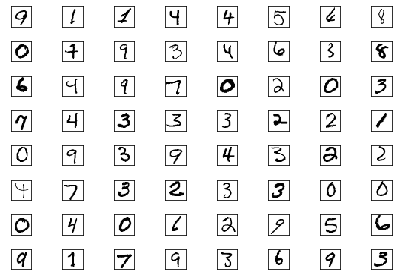

In [4]:
# data visualization
sample, label = next(iter(train_loader))
print(sample.shape)
print(label)
fig, ax = plt.subplots(nrows=8,ncols=8,sharex=True,sharey=True)
ax = ax.flatten()

for i in range(64):
    img = sample[i].numpy().reshape(28,28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [5]:
# Model
class Model(torch.nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1), nn.BatchNorm2d(64),nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1), nn.BatchNorm2d(128),nn.ReLU())

        self.pool = nn.MaxPool2d(stride=2,kernel_size=2)
        self.dense = torch.nn.Sequential(torch.nn.Linear(14*14*128,1024),
                                         torch.nn.ReLU(),
                                         torch.nn.Dropout(p=0.5),
                                         torch.nn.Linear(1024, 10))
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = x.view(-1, 14*14*128)
        x = self.dense(x)
        return x

In [6]:
# model init
model = Model()
CELoss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum)

In [7]:
# training
batch_done = 0
logs = []
for i in range(epochs):
    for data, label in train_loader:
        output = model(data)
        loss = CELoss(output,label)
#         loss.backward(retain_graph=True)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        batch_done += 1
        if batch_done % log_interval == 0:
            logs.append([batch_done,loss.item()])
            print('Epoch {}: {}/{} loss:{}'.format(i, (batch_done)%len(train_loader), len(train_loader), loss.item()))
        

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

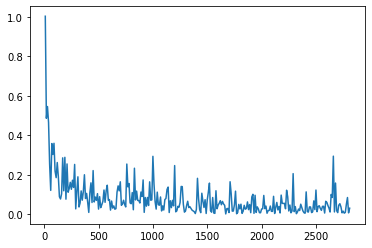

In [10]:
# loss curve visualization
logs = np.array(logs)
plt.plot(logs[:,0],logs[:,1])

In [15]:
# evaluation
model.eval()
correct = 0
for data, label in test_loader:
    output = model(data)
    _,pred = torch.max(output, dim=1)
    correct += float(torch.sum(pred == label))

print('test_acc:{}'.format(correct/len(test_dataset)))
    

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])
tensor([7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
        6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7,
        3, 9, 7, 9, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5])
tensor([8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 9,
        5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7,
        1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1])
tensor([0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0,
        3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1,
        5, 9, 8, 7, 2, 3, 0, 4, 4, 2, 4, 1, 9, 5, 7, 7])
tensor([2, 8, 2, 6, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1,
        2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 8, 2, 9, 2, 0,

        2, 8, 8, 6, 8, 1, 3, 7, 9, 0, 1, 1, 9, 7, 0, 8])
tensor([1, 7, 4, 5, 7, 1, 2, 1, 1, 3, 0, 6, 2, 1, 2, 8, 0, 7, 6, 6, 9, 3, 7, 0,
        5, 2, 8, 0, 5, 4, 3, 8, 4, 6, 6, 2, 7, 9, 5, 1, 3, 2, 4, 3, 6, 1, 9, 4,
        4, 7, 6, 5, 4, 1, 9, 9, 2, 7, 8, 0, 1, 3, 6, 1])
tensor([3, 4, 1, 1, 1, 5, 6, 0, 7, 0, 7, 2, 3, 2, 5, 2, 2, 9, 4, 9, 8, 1, 2, 1,
        6, 1, 2, 7, 8, 0, 0, 0, 8, 2, 2, 9, 2, 2, 8, 9, 9, 2, 7, 5, 1, 3, 4, 9,
        4, 1, 8, 5, 6, 2, 8, 3, 1, 2, 8, 4, 9, 9, 3, 7])
tensor([0, 7, 7, 2, 3, 2, 4, 0, 3, 9, 9, 8, 4, 1, 0, 6, 0, 9, 6, 8, 6, 1, 1, 9,
        8, 9, 2, 3, 5, 5, 9, 4, 2, 1, 9, 4, 3, 9, 6, 0, 4, 0, 6, 0, 1, 2, 3, 4,
        7, 8, 9, 0, 1, 2, 3, 4, 7, 8, 9, 0, 1, 2, 3, 4])
tensor([5, 6, 7, 8, 9, 8, 3, 4, 7, 8, 6, 3, 4, 0, 9, 7, 1, 9, 3, 8, 4, 7, 3, 0,
        9, 1, 4, 5, 4, 6, 2, 0, 6, 2, 1, 1, 1, 1, 7, 2, 4, 7, 5, 2, 9, 4, 5, 8,
        4, 2, 9, 7, 0, 0, 7, 5, 1, 1, 7, 6, 6, 6, 8, 2])
tensor([2, 7, 7, 4, 0, 2, 4, 2, 1, 8, 9, 6, 1, 0, 5, 9, 6, 9, 8, 0, 3, 0, 8

        1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6])
tensor([7, 8, 9, 1, 7, 4, 8, 1, 5, 6, 5, 7, 2, 8, 6, 3, 3, 8, 6, 5, 4, 0, 9, 1,
        7, 2, 9, 1, 5, 1, 3, 2, 2, 3, 0, 6, 4, 3, 7, 6, 9, 0, 4, 8, 1, 4, 0, 6,
        1, 2, 6, 9, 2, 2, 3, 5, 5, 1, 0, 7, 7, 9, 6, 2])
tensor([9, 4, 7, 0, 2, 3, 4, 0, 0, 8, 8, 8, 5, 1, 3, 7, 4, 9, 8, 8, 9, 0, 9, 8,
        9, 0, 2, 6, 5, 6, 7, 4, 7, 5, 4, 1, 3, 5, 3, 1, 2, 3, 4, 5, 6, 1, 2, 3,
        4, 6, 0, 1, 2, 4, 5, 6, 7, 8, 1, 7, 2, 4, 1, 4])
tensor([1, 4, 9, 6, 8, 4, 5, 3, 7, 8, 4, 3, 3, 5, 6, 7, 0, 6, 1, 6, 8, 7, 0, 1,
        5, 0, 8, 5, 0, 1, 5, 8, 4, 2, 3, 9, 7, 6, 9, 1, 9, 0, 6, 7, 1, 2, 3, 9,
        2, 4, 5, 5, 3, 7, 5, 3, 1, 8, 2, 2, 3, 0, 2, 9])
tensor([4, 9, 7, 0, 2, 7, 4, 9, 9, 2, 5, 9, 8, 3, 8, 6, 7, 0, 0, 1, 2, 3, 4, 5,
        6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
        0, 0, 7, 2, 6, 5, 5, 3, 7, 8, 6, 6, 6, 6, 4, 3])
tensor([8, 8, 3, 0, 1, 9, 0, 5, 4, 1, 9, 1, 2, 7, 0, 1, 3, 8, 2, 9, 2, 7, 4

        8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3])
tensor([4, 6, 6, 7, 8, 9, 7, 4, 6, 1, 4, 0, 9, 9, 3, 7, 8, 4, 7, 5, 8, 5, 3, 2,
        2, 0, 5, 8, 6, 0, 3, 8, 1, 0, 3, 0, 4, 7, 4, 9, 2, 9, 0, 7, 1, 7, 1, 6,
        6, 5, 6, 2, 8, 7, 6, 4, 9, 9, 5, 3, 7, 4, 3, 0])
tensor([4, 6, 6, 1, 1, 3, 2, 1, 0, 0, 1, 2, 3, 4, 7, 8, 9, 0, 1, 8, 3, 4, 5, 6,
        7, 8, 0, 1, 2, 3, 4, 7, 8, 9, 0, 8, 3, 9, 5, 5, 2, 6, 8, 4, 1, 7, 1, 3,
        3, 5, 6, 9, 1, 1, 1, 2, 1, 2, 0, 7, 7, 5, 8, 2])
tensor([9, 8, 6, 7, 3, 4, 6, 8, 7, 0, 4, 2, 7, 7, 5, 4, 3, 4, 2, 8, 1, 5, 1, 0,
        2, 3, 3, 5, 7, 0, 6, 8, 6, 3, 9, 9, 8, 2, 7, 7, 1, 0, 1, 7, 8, 9, 0, 1,
        2, 9, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 7, 8, 9, 7])
tensor([8, 6, 4, 1, 9, 3, 8, 4, 4, 7, 0, 1, 9, 2, 8, 7, 8, 2, 6, 0, 6, 5, 3, 3,
        3, 9, 1, 4, 0, 6, 1, 0, 0, 6, 2, 1, 1, 7, 7, 8, 4, 6, 0, 7, 0, 3, 6, 8,
        7, 1, 5, 2, 4, 9, 4, 3, 6, 4, 1, 7, 2, 6, 5, 0])
tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6])
test_acc:63.012738

test_acc:0.9893
